### Overfitting

Working with the Fashion MNIST dataset. 
Starting with lassifier which suffers from considerable overfitting. 
Objective: to employ regularization techniques to mitigate the overfitting problem.

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Dataset

The MNIST fashgion dataset [link](https://github.com/zalandoresearch/fashion-mnist) was build by Zalando Reasearch tem consists of monochrome images of different type of clothing, namely:
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

It is also one of the Keras built-in datasets. Let's load the images and quickly inspect it.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


Visualise some random samples.

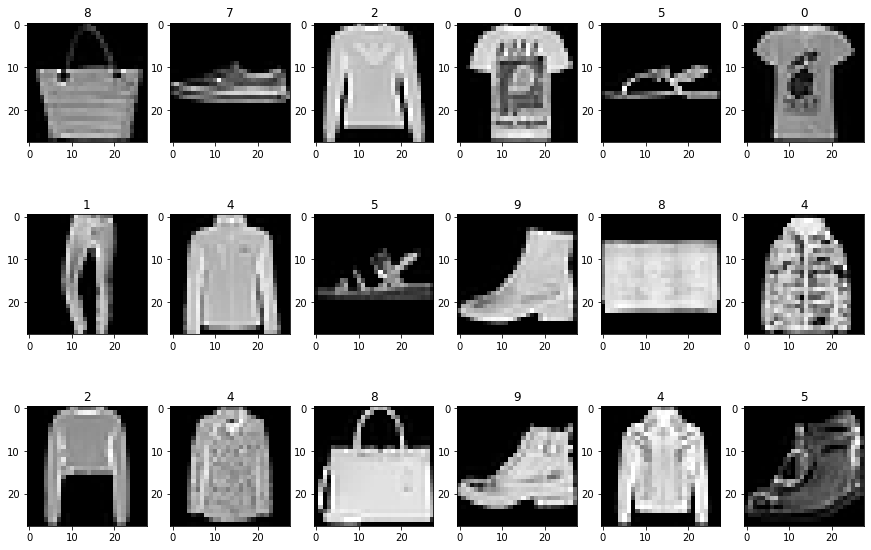

In [3]:
cnt = 1
for r in range(3):
    for c in range(6):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,6,cnt)
        plt.imshow(x_train[idx, ...], cmap='gray')
        plt.title(y_train[idx])
        cnt = cnt + 1

### Building the Classifier

Building the baseline classifier

In [4]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

In [5]:
inputs = Input(shape=(28, 28, 1))
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = Flatten()(net)
net = Dense(128)(net)
outputs = Dense(10, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


In [6]:
epochs = 50
batch_size = 64

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/50
938/938 [==============================] - 46s 47ms/step - loss: 0.3940 - accuracy: 0.8623 - val_loss: 0.3265 - val_accuracy: 0.8810
Epoch 2/50
938/938 [==============================] - 39s 42ms/step - loss: 0.2704 - accuracy: 0.9037 - val_loss: 0.2941 - val_accuracy: 0.8923
Epoch 3/50
938/938 [==============================] - 41s 44ms/step - loss: 0.2322 - accuracy: 0.9158 - val_loss: 0.3016 - val_accuracy: 0.8940
Epoch 4/50
938/938 [==============================] - 39s 42ms/step - loss: 0.2023 - accuracy: 0.9259 - val_loss: 0.3074 - val_accuracy: 0.8944
Epoch 5/50
938/938 [==============================] - 39s 42ms/step - loss: 0.1800 - accuracy: 0.9349 - val_loss: 0.3116 - val_accuracy: 0.8976
Epoch 6/50
938/938 [==============================] - 39s 42ms/step - loss: 0.1614 - accuracy: 0.9409 - val_loss: 0.3101 - val_accuracy: 0.9004
Epoch 7/50
938/938 [==============================] - 41s 43ms/step - loss: 0.1437 - accuracy: 0.9468 - val_loss: 0.3289 - val_accuracy:

Train Acc      0.994616687297821
Validation Acc 0.8779000043869019


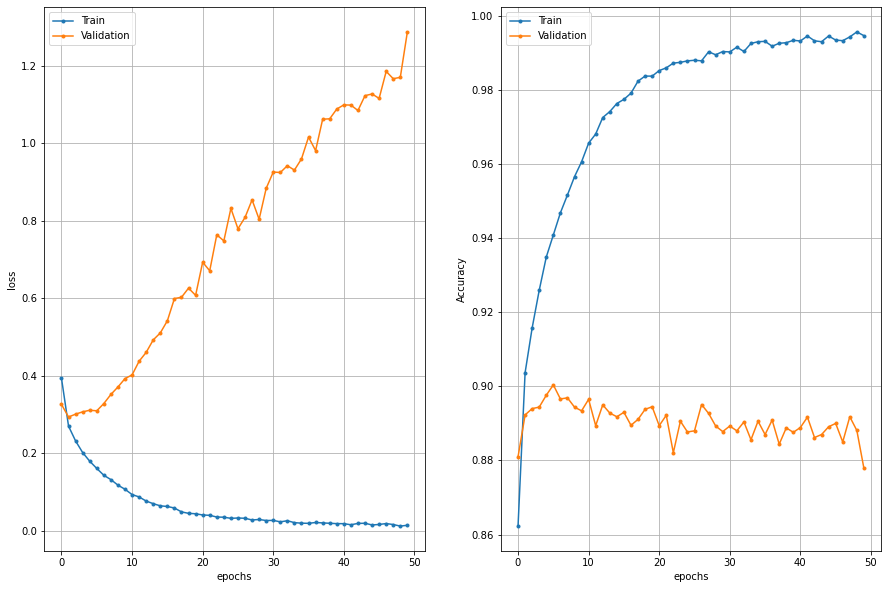

In [7]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

Classifier suffers from massive overfitting. 
The validation accuracy is around 88% while the training accuracy is close to 1.

### Reducing Overfitting

In [8]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                if np.random.rand() > 0.5:
                    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])                                
                    
            yield x_, y_

In [9]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
shape= (28, 28, 1)
inputs = Input(shape=shape)

# first: CONV => RELU => CONV => RELU => POOL layer set
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = BatchNormalization()(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)

# second: CONV => RELU => CONV => RELU => POOL layer set
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = BatchNormalization()(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = BatchNormalization()(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)

# third:  FC => RELU layer set
net = Flatten()(net)
net = Dense(512, activation="relu")(net)
net = BatchNormalization()(net)
net = Dropout(0.5)(net)

# softmax classifier
outputs = Dense(num_classes, activation="softmax")(net) #,kernel_regularizer=tf.keras.regularizers.L1(0.02)

model = Model(inputs, outputs)
model.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0   

In [10]:
# Train the network

epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience= 3)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(generator,steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[callback], validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

Epoch 1/50
937/937 [==============================] - 289s 302ms/step - loss: 0.4760 - accuracy: 0.8358 - val_loss: 0.3117 - val_accuracy: 0.8817
Epoch 2/50
937/937 [==============================] - 264s 282ms/step - loss: 0.3119 - accuracy: 0.8880 - val_loss: 0.2882 - val_accuracy: 0.8961
Epoch 3/50
937/937 [==============================] - 280s 299ms/step - loss: 0.2777 - accuracy: 0.8986 - val_loss: 0.2685 - val_accuracy: 0.9048
Epoch 4/50
937/937 [==============================] - 259s 276ms/step - loss: 0.2538 - accuracy: 0.9072 - val_loss: 0.2350 - val_accuracy: 0.9119
Epoch 5/50
937/937 [==============================] - 164s 175ms/step - loss: 0.2385 - accuracy: 0.9135 - val_loss: 0.2180 - val_accuracy: 0.9210
Epoch 6/50
937/937 [==============================] - 187s 200ms/step - loss: 0.2237 - accuracy: 0.9184 - val_loss: 0.2401 - val_accuracy: 0.9150
Epoch 7/50
937/937 [==============================] - 179s 191ms/step - loss: 0.2200 - accuracy: 0.9194 - val_loss: 0.2258 -

Train Acc      0.9523412585258484
Validation Acc 0.9383000135421753


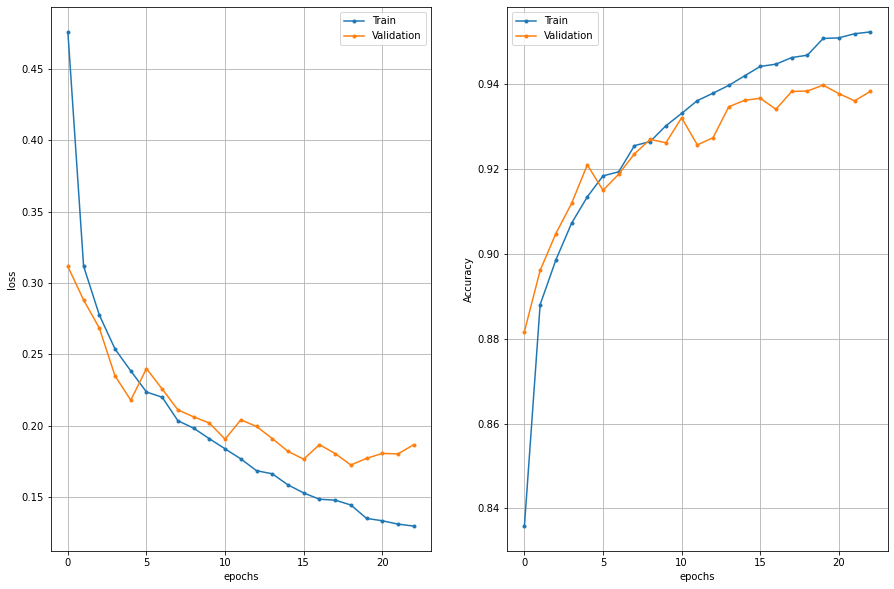

In [11]:
# Show the results

plot_history(history)

### Conlcusion


> Actions taken to reduce overfitting:
> Data augmentation;
> Added one more Conv2D layer
> Batch normalization and MaxPooling
> Added early stopping.


> Best accuracy on validation set is 0.9398
